<a href="https://colab.research.google.com/github/shivammehta007/Deep-Learning/blob/master/Task%202%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

30 points task

Deadline 02.06 23:59

### **In class**
* Load Fashion MNIST from keras.datasets
    * Train MLP and Random Forest on Fashion MNIST
* For MLP use parameters search via grid search or random search
    * Train CNN on Fashion MNIST with parameters search
* Try to reach better performance than MLP

### **Hometask**

* Train CNN autoencoder on Fashion MNIST with short parameters search
    * You should train AE using Cross-validation (not simple train/test split) and predict all data in CV manner
* Train MLP and Random Forest on the latent vector from TRAINED CNN autoencoder
* Compare all results using plot/plots



In [0]:
from __future__ import print_function
from keras.datasets import fashion_mnist
import keras
from keras.layers.core import Dense, Dropout
from keras.layers import Conv2D, MaxPool2D, Flatten, UpSampling2D, MaxPooling2D
from keras.layers import Input
from keras.utils import np_utils
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from keras.regularizers import l2,l1
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [28]:
!tensorboard --logdir=/tmp/autoencoder

TensorBoard 1.13.1 at http://91ca7cee99ab:6006 (Press CTRL+C to quit)
^C


In [4]:
# Data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


In [5]:
print(x_train.shape)
print(x_train[0].shape)
print(y_train.shape)
print(y_train[0])
print(x_test.shape)

(60000, 28, 28)
(28, 28)
(60000,)
9
(10000, 28, 28)


In [0]:
# Helper Method to print first 25 elements


def display_images(x_data, training_data=False):
    target_dict = {
     0: 'T-shirt/top',
     1: 'Trouser',
     2: 'Pullover',
     3: 'Dress',
     4: 'Coat',
     5: 'Sandal',
     6: 'Shirt',
     7: 'Sneaker',
     8: 'Bag',
     9: 'Ankle boot',
    }
    if training_data:
        x_data = x_data.reshape(15000,28,28)
    else:
        x_data = x_data.reshape(60000,28,28)
    
    plt.figure(figsize=(10,10))
    for i in range(0,25):
        plt.subplot(5,5, i+1)
        plt.imshow(x_data[i] )
        plt.title( target_dict[(y_train[i]) ])
        plt.axis('off')
        plt.xticks([])
        plt.yticks([])

# MLP

In [0]:
def prepare_data_for_MLP(x_train, y_train, x_test, y_test):
    num_classes = 10
    x_train = x_train.reshape(60000, 784)
    x_test = x_test.reshape(10000, 784)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
#     y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test_one_hot = keras.utils.to_categorical(y_test, num_classes)
    print('Data Loaded with Sample sizes')
    print('Train Sample Size: {}  '.format(x_train.shape[0]))
    print('Test Sample Size: {}'.format(x_test.shape[0]))
    return x_train, y_train, x_test, y_test, y_test_one_hot

In [8]:
x_train_mlp, y_train_mlp, x_test_mlp, y_test_mlp, y_test_mlp_one_hot = prepare_data_for_MLP(x_train, y_train, x_test, y_test)

Data Loaded with Sample sizes
Train Sample Size: 60000  
Test Sample Size: 10000


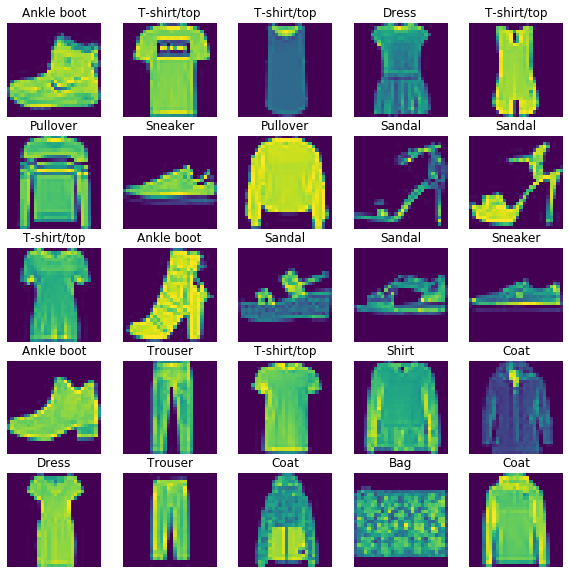

In [9]:
display_images(x_train)

In [0]:
class MLPModel:
    def __init__(self,x_train, y_train, x_test, y_test, epochs, batch_size=128):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.epochs = epochs
        self.batch_size=batch_size
        self.model = Sequential()

    
    def build_model(self, layers, activation, optimizer, regularization=None, dropout = 0.0):
        print(layers, activation, optimizer, regularization, dropout)
        for i in range(len(layers)):  
            if regularization:
                regu = l2(regularization[1]) if regularization[0] == 'l2' else l1(regularization[1])

            if i==0:
                # If First layer have to input size otherwise let it go
                self.model.add(Dense(layers[i], activation=activation, input_shape=self.x_train[0].shape, kernel_regularizer=regu))
            else:
                self.model.add(Dense(layers[i], activation=activation, kernel_regularizer=regu))

            if dropout:
                self.model.add(Dropout(dropout))
        
        self.model.add(Dense(10, activation='softmax'))
        self.model.summary()
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
        return self.model
    
    def train_model(self):
        return self.model.fit(self.x_train, self.y_train, batch_size=self.batch_size, epochs=self.epochs, verbose=2, validation_data=(self.x_test, self.y_test))      
        
    
    def print_head(self, n= 10):
        plt.figure(figsize=(20, 4))
        for i in range(1,n):
            ax = plt.subplot(2, n, i)
            plt.imshow(self.x_train[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()
        
        

In [0]:
parameters = { 'layers': [[512, 512], [512, 512, 512]], 
                     'activation': ['relu', 'elu'],
                     'optimizer' : ['adam'],
                     'dropout' : [0.2],
                     'regularization' : [ ('l2', 0.001) ]
                   }

In [12]:

m = MLPModel(x_train_mlp, y_train_mlp, x_test_mlp, y_test_mlp, 10)
model = KerasClassifier(build_fn=m.build_model,epochs=10, batch_size=128)
grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=3)
grid_result = grid_search.fit(x_train_mlp, y_train_mlp)



/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[512, 512] relu adam ('l2', 0.001) 0.2
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706


In [14]:
final_model = grid_search.best_estimator_
final_parameters = grid_search.best_params_
print(final_parameters)

{'activation': 'relu', 'dropout': 0.2, 'layers': [512, 512], 'optimizer': 'adam', 'regularization': ('l2', 0.001)}


In [0]:
y_predicted_mlp = final_model.predict(x_test_mlp)

In [16]:
y_predicted_mlp[:10]

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], dtype=uint8)

In [0]:
# Save Model
final_model.model.save('MLP_best_model.h5')

In [17]:
mlp_accuracy_score = accuracy_score(y_predicted_mlp, y_test_mlp)* 100
print(mlp_accuracy_score)

86.46000000000001


# RandomForest On Data

In [0]:
rf = RandomForestClassifier(n_estimators=64, n_jobs=-1)
fit_result = rf.fit(x_train_mlp, y_train_mlp)


In [0]:
y_pred_mlp = rf.predict(x_test_mlp)


In [20]:
y_pred_mlp[:10]

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], dtype=uint8)

In [21]:
# Print result
rf_accuracy_score = accuracy_score(y_test_mlp, y_pred_mlp) * 100
print(rf_accuracy_score)

87.26


# Convulational Model

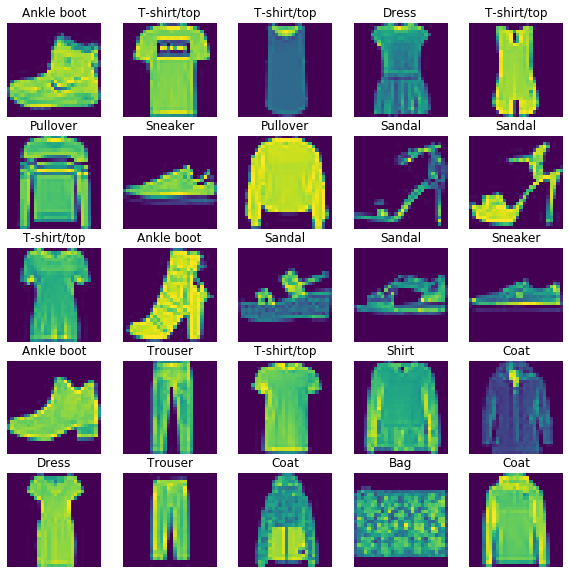

In [7]:
# See first 25 data
display_images(x_train)

In [0]:
class DataPreparation:
    def __init__(self, x_data, y_data, normalized=True):
        self.X = x_data.reshape(x_data.shape[0], 28,28,1)
        # One hot encoded
        self.Y = np_utils.to_categorical(y_data)
        
        if normalized:
            self.__normalize_data__()


    def __normalize_data__(self):
        self.X = self.X/np.float(255)
        
    
    def add_noise(self ,noise_factor= 0.5, mu=0, std=1):
        self.noise_factor = noise_factor 
        noise = np.random.normal(mu, std, size=self.X.shape)
        self.X = self.X + noise_factor * noise
        self.X = np.clip(self.X, 0., 1.)
     
    def convert_y_to_non_hot_encoding(self):
        self.Y_non_hot = [np.where(r == 1)[0][0] for r in self.Y]
        return self.Y_non_hot
       
   


In [0]:
train_data  = DataPreparation(x_train, y_train)
test_data = DataPreparation(x_test, y_test)

In [24]:
print(train_data.Y[:5])
print(train_data.X.shape)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(60000, 28, 28, 1)


In [0]:
parameters = {
    'layers' : [[('Conv2D' , 64 ), ('Conv2D' , 32)], [( 'Conv2D', 64) , ('Dense' , 32 )] ],
    'activation' : ['relu'],
    'optimizer' : ['adam']
}

In [0]:
class ConvolutionalModel:
    def __init__(self ,x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train
        self.model = Sequential()
    
    def build_model(self, layers, activation, optimizer, dropout = 0.0 ):
        print('Parameters : Layers: {}, Activation: {}, optimizer: {}, input_shape : {}'.format(layers,activation,optimizer, self.x_train[0].shape))
        
       
        i = 0
        first_dense = True
        for layer in layers:
            print(layer)
            i+=1
            # Adding Input to the First Layer
            if i==1 :
                self.model.add(Conv2D(layer[1], kernel_size=3, activation=activation, input_shape=self.x_train[0].shape))
                self.model.add(MaxPool2D(pool_size=2))

            
            
            if layer[0] == 'Conv2D':
                self.model.add(Conv2D(layer[1], kernel_size=3, activation=activation))
                self.model.add(MaxPool2D(pool_size=2))
            else:
                if first_dense:
                    first_dense = False
                    self.model.add(Flatten())

                self.model.add(Dense(layer[1], activation=activation))
            
        # Adding Final Layer
        if first_dense:
            self.model.add(Flatten())

        self.model.add(Dense(10, activation='softmax'))
        self.model.summary()
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
        
        return self.model
    
    def predict(self, X_data):
        return self.model.predict(X_data)
        
    

In [28]:
model = ConvolutionalModel(train_data.X, train_data.Y)
grid_search_classifier = KerasClassifier(build_fn=model.build_model, epochs=10, batch_size=128)
grid_search_cnn = GridSearchCV(estimator=grid_search_classifier, param_grid=parameters, cv=3 )
grid_search_fit = grid_search_cnn.fit(train_data.X, train_data.Y)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Parameters : Layers: [('Conv2D', 64), ('Conv2D', 32)], Activation: relu, optimizer: adam, input_shape : (28, 28, 1)
('Conv2D', 64)
('Conv2D', 32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 32)          18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 32)          0      

In [29]:
final_model_cnn = grid_search_cnn.best_estimator_
final_parameters_cnn = grid_search_cnn.best_params_
print(final_parameters_cnn)

{'activation': 'relu', 'layers': [('Conv2D', 64), ('Dense', 32)], 'optimizer': 'adam'}


In [0]:
y_predicted_cnn = final_model_cnn.predict(test_data.X)

In [34]:
cnn_accuracy = accuracy_score(y_predicted_cnn, y_test) * 100
print(cnn_accuracy)

90.98


## Adding Noise Into the Data to train a decoder 

In [0]:
# How to Add noise Check

train_noisy = DataPreparation(x_train, y_train)
train_noisy.add_noise(0.2)
test_noisy = DataPreparation(x_test, y_test)
test_noisy.add_noise(0.2)

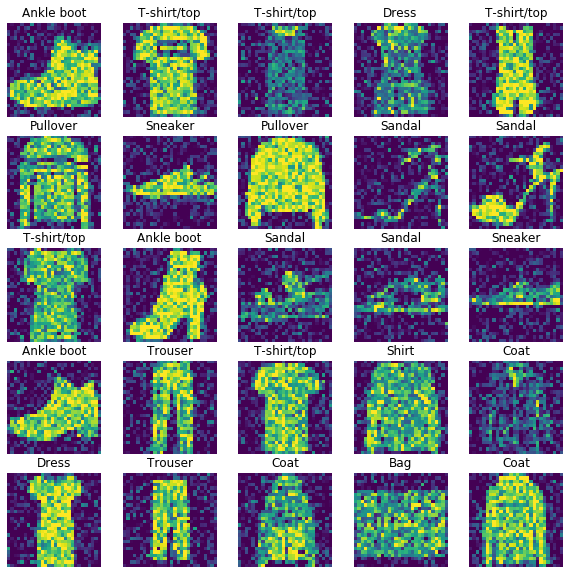

In [36]:
display_images(train_noisy.X)

In [0]:
parameters = {
                'loss' : ['adadelta'],
                'activation' : ['relu']

}

In [0]:
class Decoder:
    def __init__(self, epochs=20):
        self.epochs = epochs    

    
    def fit(self,x_train_noisy, x_train, x_test_noisy, x_test, activation='relu', optimizer='adadelta'):
        print(x_train_noisy[0].shape)
        
        input_img = Input(shape=x_train_noisy[0].shape)
        
        encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
        encoded = MaxPooling2D((2, 2), padding='same')(encoded)
        encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
        encoded = MaxPooling2D((2, 2), padding='same')(encoded)

        # at this point the representation is (7, 7, 32)

        decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
        decoded = UpSampling2D((2, 2))(decoded)
        decoded = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
        decoded = UpSampling2D((2, 2))(decoded)
        decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)

        self.autoencoder = Model(input_img, decoded)
        self.autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')
        
        
        
        history = self.autoencoder.fit(x_train_noisy, x_train, epochs = self.epochs, batch_size=256, verbose=2,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))
        
        
        return history
    
    def predict(self, x_train):
        denoised_image = self.autoencoder.predict(x_train)
        
        return denoised_image

In [0]:
def get_data_and_noisy_data_from_fold_results(train_index, test_index):
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    x_test_fold = x_train[test_index]
    y_test_fold = y_train[test_index]
    
    # Noisy Data
    train_data_noisy = DataPreparation(x_train_fold, y_train_fold)
    train_data_noisy.add_noise(0.3)
    test_data_noisy = DataPreparation(x_test_fold, y_test_fold)
    test_data_noisy.add_noise(0.3)
    
    # Normal Data
    train_data = DataPreparation(x_train_fold, y_train_fold)
    test_data = DataPreparation(x_test_fold, y_test_fold)
    print('Shape of Train_data : {} {} , Train_data_noisy : {} {} , Test_data: {} {}, Test_data_noisy: {} {}'.format(train_data.X.shape, train_data.Y.shape, train_data_noisy.X.shape, train_data_noisy.Y.shape, test_data.X.shape, test_data.Y.shape, test_data_noisy.X.shape, test_data_noisy.Y.shape))
    return train_data, train_data_noisy, test_data, test_data_noisy

## Training A Decoder Using KFold Validation

In [0]:
decoder_history = [] 
denoised_images = []

In [41]:
skf = StratifiedKFold(n_splits=4, random_state=None)

# K Fold Split the original Data
split = skf.split(x_train, y_train)

decoder = Decoder()

for train_index, test_index in split:
    train_data, train_data_noisy, test_data, test_data_noisy = get_data_and_noisy_data_from_fold_results(train_index, test_index)
    print('Data After Adding Noise and One Hot Encoded')
    print(train_data.X.shape, train_data.Y.shape)
    print(test_data.X.shape, test_data.Y.shape)
    decoder_history.append(decoder.fit(train_data_noisy.X, train_data.X, test_data_noisy.X, test_data.X ))
    denoised_images.append(( test_data.Y, decoder.predict(test_data_noisy.X), test_data.X ) )

    

    

Shape of Train_data : (45000, 28, 28, 1) (45000, 10) , Train_data_noisy : (45000, 28, 28, 1) (45000, 10) , Test_data: (15000, 28, 28, 1) (15000, 10), Test_data_noisy: (15000, 28, 28, 1) (15000, 10)
Data After Adding Noise and One Hot Encoded
(45000, 28, 28, 1) (45000, 10)
(15000, 28, 28, 1) (15000, 10)
(28, 28, 1)
Train on 45000 samples, validate on 15000 samples
Epoch 1/20
 - 7s - loss: 0.3831 - val_loss: 0.3257
Epoch 2/20
 - 4s - loss: 0.3150 - val_loss: 0.3054
Epoch 3/20
 - 4s - loss: 0.3039 - val_loss: 0.2999
Epoch 4/20
 - 4s - loss: 0.2982 - val_loss: 0.2988
Epoch 5/20
 - 4s - loss: 0.2947 - val_loss: 0.2916
Epoch 6/20
 - 4s - loss: 0.2927 - val_loss: 0.2921
Epoch 7/20
 - 4s - loss: 0.2908 - val_loss: 0.2902
Epoch 8/20
 - 4s - loss: 0.2896 - val_loss: 0.2870
Epoch 9/20
 - 4s - loss: 0.2883 - val_loss: 0.2852
Epoch 10/20
 - 4s - loss: 0.2875 - val_loss: 0.2842
Epoch 11/20
 - 4s - loss: 0.2869 - val_loss: 0.2862
Epoch 12/20
 - 4s - loss: 0.2861 - val_loss: 0.2842
Epoch 13/20
 - 4s -

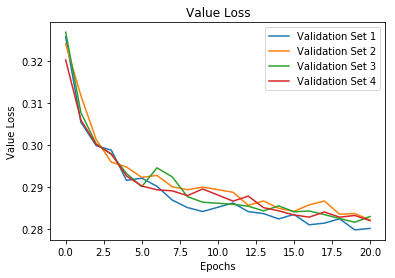

In [42]:
# Plot Value Loss with each cross validation iteration

x = np.linspace(0, 20, 20)
x = np.round(x)

for i in range(len(decoder_history)):
    plt.plot(x,decoder_history[i].history['val_loss'])
    plt.title('Value Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Value Loss')
    plt.legend(['Validation Set 1', 'Validation Set 2', 'Validation Set 3', 'Validation Set 4'])
plt.show()

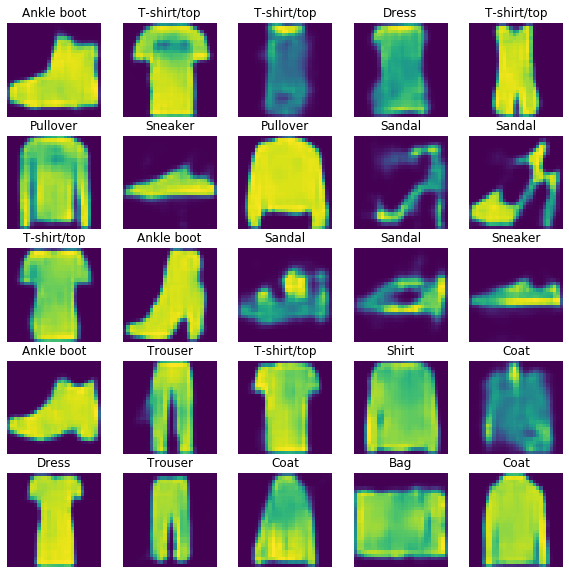

In [43]:
display_images(denoised_images[0][1],training_data=True)

## Denoising the Data and Applying CNN and Random Forest on Denoised Data

Shape : X : (60000, 28, 28, 1)
Y : (60000, 10)


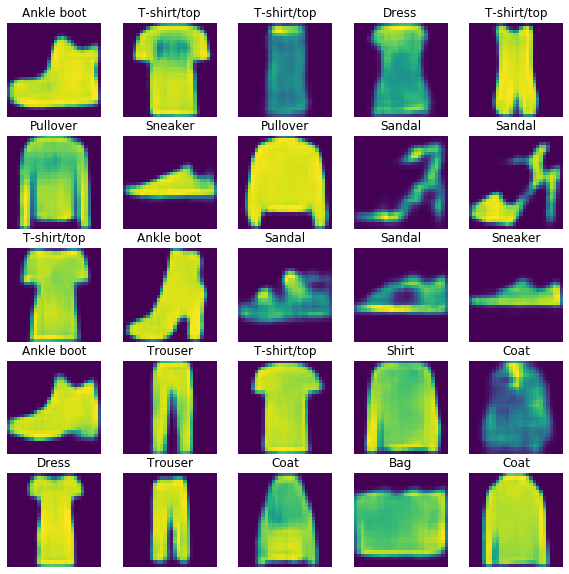

In [44]:
# Denoising Training Data with AutoEncoder

X_denoised = decoder.predict(train_noisy.X)
Y_denoised = train_noisy.Y
test_X_denoised = decoder.predict(test_noisy.X)
test_Y_denoised = test_noisy.Y
display_images(X_denoised)
print('Shape : X : {}\nY : {}'.format(X_denoised.shape, Y_denoised.shape))

### CNN on Denoised Data

In [45]:
denoised_cnn = ConvolutionalModel(X_denoised, Y_denoised)
denoised_cnn.build_model([( 'Conv2D', 64) , ('Dense' , 32 )], 'relu', 'adam')
denoised_cnn.model.fit(X_denoised, Y_denoised, batch_size=128, epochs=20, verbose=2, validation_data=(test_X_denoised, test_Y_denoised))

Parameters : Layers: [('Conv2D', 64), ('Dense', 32)], Activation: relu, optimizer: adam, input_shape : (28, 28, 1)
('Conv2D', 64)
('Dense', 32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_57 (Dense)             (None, 32)                51232    

In [46]:
score = denoised_cnn.model.evaluate(test_X_denoised, test_Y_denoised, verbose=0)
print('CNN accuracy on Denoised Data:', score[1]*100)
cnn_decoded_accuracy = score[1]*100

CNN accuracy on Denoised Data: 86.16


### Random Forest on Denoised Data

In [47]:
# Preparing Data for Random Forest

x_train_denoised_rf, y_train_denoised_rf, x_test_denoised_rf, y_test_denoised_rf, y_test_denoised_rf_one_hot = prepare_data_for_MLP(X_denoised, Y_denoised, test_X_denoised, test_Y_denoised)

Data Loaded with Sample sizes
Train Sample Size: 60000  
Test Sample Size: 10000


In [0]:
rf_denoised = RandomForestClassifier(n_estimators=64, n_jobs=-1)
fit_result_denoised = rf_denoised.fit(x_train_denoised_rf, y_train_denoised_rf)


In [0]:
y_pred_denoised = rf_denoised.predict(x_test_denoised_rf)

In [50]:
rf_denoised_accuracy = accuracy_score(y_pred_denoised, y_test_denoised_rf)* 100
print(rf_denoised_accuracy)

78.01


# Comparing All the Results

In [0]:
accuracy = {
    'MLP Accuracy' : np.round(mlp_accuracy_score,2),
    'Random Forest Accuracy' : rf_accuracy_score,
    'CNN Accuracy' : cnn_accuracy,
    'CNN Decoded Denoised Accuracy' : cnn_decoded_accuracy,
    'Random Forest Decoded Denoised Accuracy' : rf_denoised_accuracy
}

In [54]:
print(accuracy)

{'MLP Accuracy': 86.46, 'Random Forest Accuracy': 87.26, 'CNN Accuracy': 90.98, 'CNN Decoded Denoised Accuracy': 86.16, 'Random Forest Decoded Denoised Accuracy': 78.01}


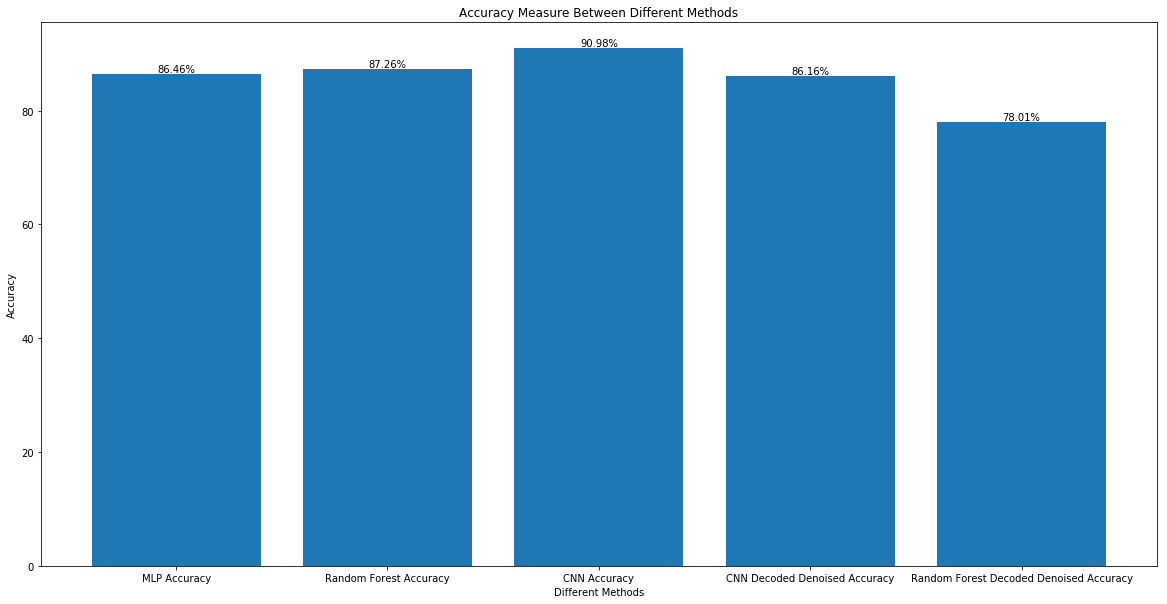

In [76]:
# Display Graph Measure Of Accuracy Scores

plt.figure(figsize=(20,10))
bar_heights = plt.bar(accuracy.keys(), accuracy.values())
plt.ylabel('Accuracy')
plt.xlabel('Different Methods')
plt.title('Accuracy Measure Between Different Methods')
for rect in bar_heights:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '{}%'.format(height), ha='center', va='bottom')
plt.show()

